In [1]:
using DelimitedFiles
using PyPlot
using Random
using Setfield
using Statistics
using ProgressMeter
using JLD2
using HDF5
using Printf
using FileIO
using DataStructures
using CUDA

using Revise

using CMBLensing

┌ Info: Precompiling CUDA [052768ef-5323-5732-b1bb-66c8b64840ba]
└ @ Base loading.jl:1278


In [2]:
Cℓ = camb(ωb=0.02268, ωc=0.1081, nₛ=0.961, H0=72.4, θs=nothing, logA=log(2.41*10), k_pivot=0.05, ℓmax=10000);

# Parallel setup

In [44]:
using Distributed, ClusterManagers
em = ElasticManager(addr=:auto, port=0);

In [147]:
em

ElasticManager:
  Active workers : [ 22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41]
  Number of workers to be added  : 0
  Terminated workers : [ 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
  Worker connect command : 
    /global/u1/m/marius/src/julia-1.4/usr/bin/julia --project=/global/u1/m/marius/work/SehgalRadioPolarizedSources/Project.toml -e 'using ClusterManagers; ClusterManagers.elastic_worker("jEkcetP6IPKx0sig","128.55.144.144",43221)'

In [148]:
@everywhere using CMBLensing

# Load files

In [3]:
sims = 1:40;

In [4]:
datadir = "h5output/sehgal_maps";

In [5]:
fluxcuts = (2,5,10,Inf);

## Load originals

In [61]:
κs = @showprogress map(sims) do i
    ud_grade(FlatMap(Float32.(h5read("$datadir/radio_sources/cutouts/kappa_sehgal_patch$i.h5", "map")), θpix=1//2), 2)
end

ϕs = map(κs) do κ
    -2*(∇²\κ)
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


In [ ]:
gs = Dict();

In [62]:
gs_radio = @showprogress map(sims) do i 
    ud_grade(
        FlatQUMap((Float32.(h5read("$datadir/radio_sources/cutouts/ps_sehgal_$(pol)_patch$i.h5", "map")) for pol in "QU")..., θpix=1//2), 
        2, 
        anti_aliasing=false, 
        deconv_pixwin=false
    )
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


In [79]:
gs_ir = @showprogress map(sims) do sim
    mapreduce(+, ["gal_S_$(S)" for S=1:9]) do bin
        ud_grade(
            FlatQUMap((Float32.(h5read("$datadir/ir_sources/cutouts/ir_IR$(bin)_sehgal_$(pol)_patch$(sim).h5", "map")) for pol="QU")..., θpix=1//2), 2,
            anti_aliasing=false, deconv_pixwin=false
        )
    end
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:03:52


In [81]:
Ms_radio = Dict(map(fluxcuts) do fluxcut
    if fluxcut == Inf
        fluxcut => one.(sims)
    else
        fluxcut => @showprogress map(sims) do i
            M = ud_grade(
                FlatMap(Float32.(h5read("$datadir/radio_sources/cutouts/ps_mask_$(fluxcut)mJy_T_patch$(i).h5", "map")), θpix=1//2), 2, 
                anti_aliasing=false, deconv_pixwin=false
            )
            Diagonal(FlatQUMap(M,M))
        end
    end
end);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


In [82]:
# @save "h5output/cutouts.jld2" ϕs κs gs_ir gs_radio Ms_radio;

## Load pre-processed

In [6]:
@load "h5output/cutouts.jld2"

5-element Array{Symbol,1}:
 :ϕs
 :κs
 :gs_ir
 :gs_radio
 :Ms_radio

In [15]:
ϕs = cu.(ϕs)
κs = cu.(κs)
gs_ir = cu.(gs_ir)
gs_radio = cu.(gs_radio)
Ms_radio = Dict(2 => cu.(Ms_radio[2]), 5 => cu.(Ms_radio[5]), 10 => cu.(Ms_radio[10]), Inf => Ms_radio[Inf]);

# Check power

In [16]:
μKarcmin_gs_radio = Dict(map(collect(Ms_radio)) do (fluxcut,Ms)
    fluxcut => mean(sims) do i
        sqrt(mean(get_Cℓ(Ms[i] * gs_radio[i], which=:QQ)[1000:2000]) / deg2rad(1/60)^2)
    end
end)

Dict{Real,Float64} with 4 entries:
  Inf => 0.632798
  10  => 0.102093
  2   => 0.049197
  5   => 0.076181

In [17]:
μKarcmin_gs_ir = mean(sims) do i
    sqrt(mean(get_Cℓ(gs_ir[i], which=:QQ)[1000:2000]) / deg2rad(1/60)^2)
end

0.07403972343490431

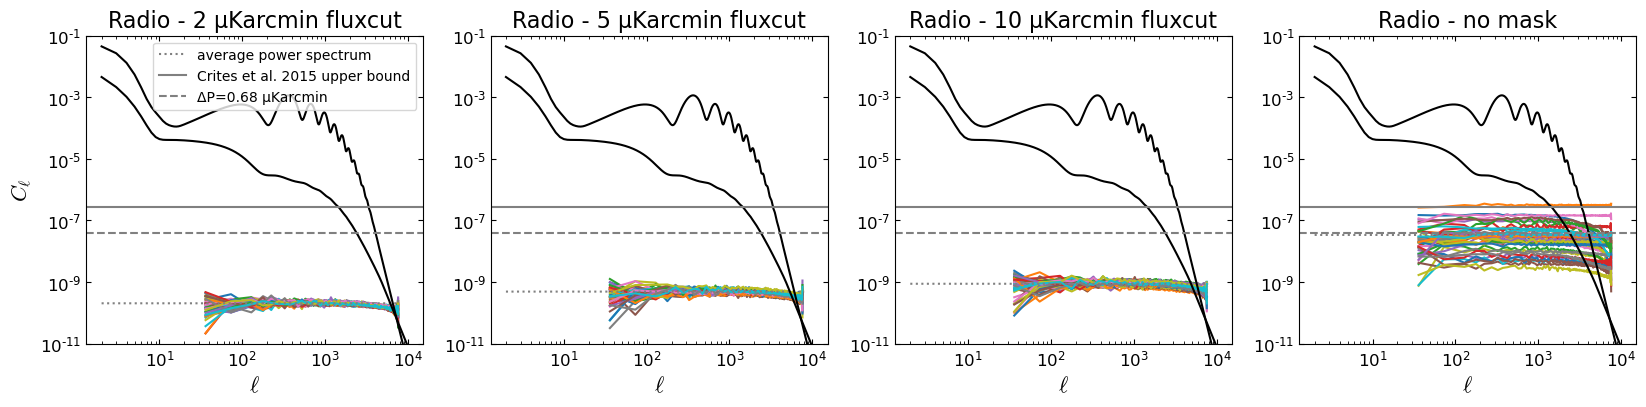

In [18]:
figure(figsize=(20,4))

for (i,fluxcut) in enumerate(fluxcuts)

    subplot(1,4,i)
    for i=sims
        loglog(get_Cℓ(Ms_radio[fluxcut][i] * gs_radio[i], which=:QQ))
    end

    loglog(noiseCℓs(μKarcminT=μKarcmin_gs_radio[fluxcut]/√2, ℓknee=0).EE,"gray",ls=":", label="average power spectrum")

    loglog(Cℓ.total.EE, "k")
    loglog(Cℓ.total.BB, "k")
    axhline(2.8e-7, c="gray", label="Crites et al. 2015 upper bound")
    axhline(3.9e-8, c="gray", ls="--", label="ΔP=0.68 μKarcmin")

    ylim(1e-11, 1e-1)
        
    i==1 && legend(fontsize=10,frameon=true)
    xlabel(L"$\ell$")
    i==1 && ylabel(L"$C_\ell$")
    title("Radio - " * (fluxcut == Inf ? "no mask" : "$(fluxcut) μKarcmin fluxcut"))

end

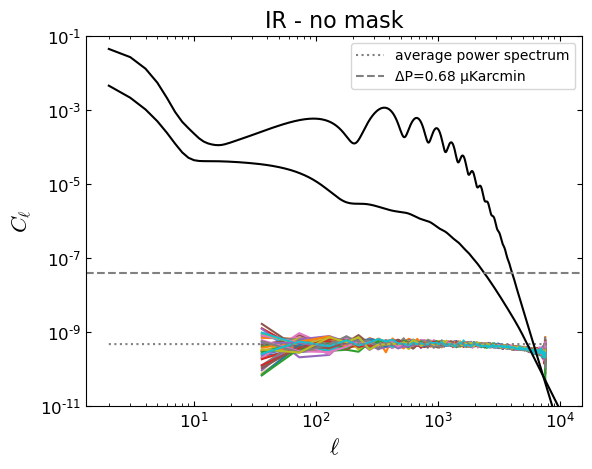

PyObject Text(0.5, 1.0, 'IR - no mask')

In [19]:
for i in sims
    loglog(get_Cℓ(gs_ir[i], which=:QQ))
end

loglog(noiseCℓs(μKarcminT=μKarcmin_gs_ir/√2, ℓknee=0).EE,"gray",ls=":", label="average power spectrum")

loglog(Cℓ.total.EE, "k")
loglog(Cℓ.total.BB, "k")
axhline(3.9e-8, c="gray", ls="--", label="ΔP=0.68 μKarcmin")

ylim(1e-11, 1e-1)

legend(fontsize=10,frameon=true)
xlabel(L"$\ell$")
ylabel(L"$C_\ell$")
title("IR - no mask")

In [20]:
LP = LowPass(1100,Δℓ=200).diag.Wℓ
HP = HighPass(901,Δℓ=200).diag.Wℓ
Cℓϕϕ = CMBLensing.extrapolate_Cℓs(
    2:10000, 
    2:6000, 
    nan2zero.((LP * Cℓ.total.ϕϕ)[2:6000]) + nan2zero.((HP * CMBLensing.smooth(mean(get_Cℓ(ϕ) for ϕ in ϕs), xscale=:log, yscale=:log))[2:6000])
);

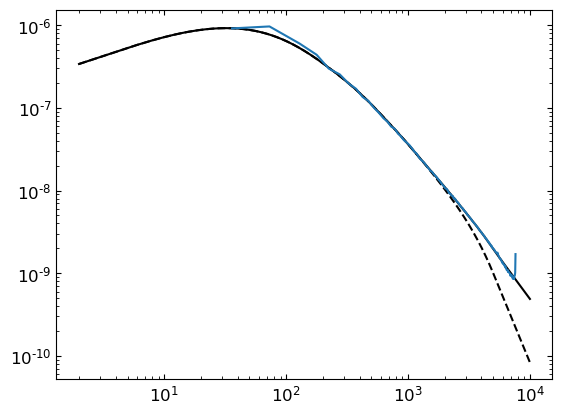

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x2aac0dea2390>

In [21]:
loglog(ℓ⁴*Cℓϕϕ,"k")
loglog(ℓ⁴*Cℓ.total.ϕϕ,"k--")
loglog(mean(get_ℓ⁴Cℓ(ϕ) for ϕ in ϕs))

In [22]:
@set! Cℓ.total.ϕϕ = Cℓϕϕ;

In [140]:
@save "Cl.jld2" Cℓ

# Reconstruct

In [23]:
noises = Dict(
    :deep => (μKarcminT=0.96/√2, beamFWHM=2.3, ℓknee=200, αknee=2),
    :wide => (μKarcminT=2.9/√2,  beamFWHM=2.3, ℓknee=700, αknee=1.4),
)

Dict{Symbol,NamedTuple{(:μKarcminT, :beamFWHM, :ℓknee, :αknee),T} where T<:Tuple} with 2 entries:
  :deep => (μKarcminT = 0.678823, beamFWHM = 2.3, ℓknee = 200, αknee = 2)
  :wide => (μKarcminT = 2.05061, beamFWHM = 2.3, ℓknee = 700, αknee = 1.4)

In [151]:
function get_MAPs(;Ms, gs, ϕs, noise_kwargs, ℓmax_data, fluxcut, polfrac_scale)
        
    @unpack ds = load_sim_dataset(;
        Cℓ = Cℓ,
        θpix = 2,
        Nside = 300,
        pol = :P,
        bandpass_mask = LowPass(ℓmax_data),
        noise_kwargs...
    )
    @unpack B = ds

    μKarcmin_g = mean(sqrt(mean(get_Cℓ(Ms[fluxcut][i] * gs[i], which=:QQ)[1000:2000]) / deg2rad(1/60)^2) for i=sims)
    Cℓg = noiseCℓs(μKarcminT=polfrac_scale*μKarcmin_g/√2, beamFWHM=0, ℓknee=0)
    Cg = Cℓ_to_Cov(Flat(Nside=300, θpix=2), Float32, S2, Cℓg.EE, Cℓg.BB)
    
    @showprogress pmap(sims) do sim

        sim′ = mod(sim,maximum(sims))+1

        Dict(map([

            (:nofg,     :fgcov, 0,        Ms[fluxcut][sim],  ϕs[sim]),
            (:corrfg,   :fgcov, gs[sim] , Ms[fluxcut][sim],  ϕs[sim]),
            (:uncorrfg, :fgcov, gs[sim′], Ms[fluxcut][sim′], ϕs[sim]),
#             (:nofg,     :nocov, 0,        Ms[fluxcut][sim],  ϕs[sim]),
#             (:corrfg,   :nocov, gs[sim] , Ms[fluxcut][sim],  ϕs[sim]),
#             (:uncorrfg, :nocov, gs[sim′], Ms[fluxcut][sim′], ϕs[sim])

        ]) do (g_in_data, g_in_cov, g, M, ϕ)

            ds′ = resimulate(ds, ϕ=ϕ, seed=sim).ds
            if g_in_cov != :nocov
                ds′.Cn += polfrac_scale^2*B*Cg*B'
            end
            if g_in_data != :nofg
                ds′.d  += polfrac_scale*B*M*g
            end

            (g_in_data,g_in_cov) => 
                try
                    fJ,ϕJ = MAP_joint(
                        ds′,
                        Nϕ       = :qe,
                        nsteps   = 20,
                        progress = false,
                        αmax     = 0.4,
                    )
                    (f=fJ,ϕ=ϕJ)
                catch
                    @warn "$sim $g_in_data $g_in_cov"
                    nothing
                end

        end...)

    end
    
end

get_MAPs (generic function with 1 method)

In [152]:
map(collect(noises)) do (noise_key, noise_kwargs)
    map([3000,5000]) do ℓmax_data
        map([2,10]) do fluxcut
            map([1,2]) do polfrac_scale
                filename = "MAPs/radio_148GHz_S4$(noise_key)_lmax$(ℓmax_data)_fluxcut$(fluxcut)mJy_polfracscale$(polfrac_scale).jld2"
                if !ispath(filename)
                    println(filename)
                    MAPs = get_MAPs(;@namedtuple(Ms=Ms_radio, gs=gs_radio, ϕs, noise_kwargs, ℓmax_data, fluxcut, polfrac_scale)...)
                    save(filename, "MAPs", MAPs)
                end
            end
        end
    end
end;

MAPs/radio_148GHz_S4deep_lmax3000_fluxcut2mJy_polfracscale1.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:10:10


MAPs/radio_148GHz_S4deep_lmax3000_fluxcut2mJy_polfracscale2.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:08:55


MAPs/radio_148GHz_S4deep_lmax3000_fluxcut10mJy_polfracscale1.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:08:49


MAPs/radio_148GHz_S4deep_lmax3000_fluxcut10mJy_polfracscale2.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:08:53


MAPs/radio_148GHz_S4deep_lmax5000_fluxcut2mJy_polfracscale1.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:08:02


MAPs/radio_148GHz_S4deep_lmax5000_fluxcut2mJy_polfracscale2.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:08:12


MAPs/radio_148GHz_S4deep_lmax5000_fluxcut10mJy_polfracscale1.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:08:06


MAPs/radio_148GHz_S4deep_lmax5000_fluxcut10mJy_polfracscale2.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:08:19


MAPs/radio_148GHz_S4wide_lmax3000_fluxcut2mJy_polfracscale1.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:09:26


MAPs/radio_148GHz_S4wide_lmax3000_fluxcut2mJy_polfracscale2.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:09:29


MAPs/radio_148GHz_S4wide_lmax3000_fluxcut10mJy_polfracscale1.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:09:25


MAPs/radio_148GHz_S4wide_lmax3000_fluxcut10mJy_polfracscale2.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:09:27


MAPs/radio_148GHz_S4wide_lmax5000_fluxcut2mJy_polfracscale1.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:09:25


MAPs/radio_148GHz_S4wide_lmax5000_fluxcut2mJy_polfracscale2.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:09:18


MAPs/radio_148GHz_S4wide_lmax5000_fluxcut10mJy_polfracscale1.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:09:28


MAPs/radio_148GHz_S4wide_lmax5000_fluxcut10mJy_polfracscale2.jld2


Progress: 100%|█████████████████████████████████████████| Time: 0:09:25


In [ ]:
map(collect(noises)) do (noise_key, noise_kwargs)
    map([3000,5000]) do ℓmax_data
        map([1,2]) do polfrac_scale
            filename = "MAPs/ir_145GHz_S4$(noise_key)_lmax$(ℓmax_data)_nomask_polfracscale$(polfrac_scale).jld2"
            println(filename)
            MAPs = get_MAPs(;@namedtuple(Ms=DefaultDict(DefaultDict(1)), gs=gs_ir, ϕs, noise_kwargs, ℓmax_data, fluxcut, polfrac_scale)...)
            save(filename, "MAPs", MAPs)
        end
    end
end;

# Analyze

In [52]:
ℓedges = [25, 50, 75, 100, 134, 182, 245, 331, 447, 603, 814, 1098, 1482, 1998, (3000:1000:6000)...];

In [53]:
ℓedges = 10 .^ range(log10(25), log10(6000), length=10);

In [54]:
noise_key = :wide
ℓmax_data = 3000
polfrac_scale = 1
fluxcut = 10;

In [155]:
@time map(collect(noises)) do (noise_key, noise_kwargs)
    map([3000,5000]) do ℓmax_data
        map([2,10]) do fluxcut
            map([1,2]) do polfrac_scale

                filename = "MAPs/radio_148GHz_S4$(noise_key)_lmax$(ℓmax_data)_fluxcut$(fluxcut)mJy_polfracscale$(polfrac_scale).jld2"
                
                if isfile(filename)
                
                    MAPs = load(filename, "MAPs");

                    Cℓ_bias  = Cℓ.total.ϕϕ * ((1/mean(get_ρℓ(MAPs[i][:corrfg,:fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1) - (1/mean(get_ρℓ(MAPs[i][:nofg,:fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1))
                    Cℓ_noise = Cℓ.total.ϕϕ *  (1/mean(get_ρℓ(MAPs[i][:corrfg,:fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1);
                    fsky = (noise_key==:deep ? 1500 : 20000) / 42000
                    σℓ = (Cℓ.total.ϕϕ + Cℓ_noise) * CMBLensing.FuncCℓs(ℓ -> √(2/((2ℓ+1)*fsky)));

                    Tℓ = mean(get_Cℓ(MAPs[i][:nofg,:fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims) / mean(get_Cℓ(ϕs[i], ℓedges=ℓedges) for i=sims)

                    
                    map([100:2000, 100:3000]) do ℓrange_Aϕ

                        b̂ = sum((Cℓ_bias / σℓ^2)[ℓrange_Aϕ]) / sum((1 / σℓ^2)[ℓrange_Aϕ])
                        σb̂ = 1 / sqrt(sum((1 / σℓ^2)[ℓrange_Aϕ]))
                        b̂ / σb̂

                        fgcov=:fgcov

                        figure()

                        loglog(ℓ⁴ * Cℓ.total.ϕϕ,"k")
                        for i=sims
                            loglog(ℓ⁴ * Cℓ.total.ϕϕ *  (1/get_ρℓ(MAPs[i][:corrfg,  fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1), "C0", alpha=0.1)
#                             loglog(ℓ⁴ * Cℓ.total.ϕϕ * ((1/get_ρℓ(MAPs[i][:corrfg,  fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1) - (1/get_ρℓ(MAPs[i][:nofg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1)),"C1",alpha=0.1)
#                             loglog(ℓ⁴ * Cℓ.total.ϕϕ * ((1/get_ρℓ(MAPs[i][:uncorrfg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1) - (1/get_ρℓ(MAPs[i][:nofg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges)^2 - 1)),"C2",alpha=0.1)    
                        end
                        loglog(ℓ⁴ * Cℓ.total.ϕϕ * ( 1/mean(get_ρℓ(MAPs[i][:corrfg,  fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1), 
                            "C0", label="noise")
                        loglog(ℓ⁴ * Cℓ.total.ϕϕ * ((1/mean(get_ρℓ(MAPs[i][:corrfg,  fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1) - (1/mean(get_ρℓ(MAPs[i][:nofg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1)),
                            "C1", label="foreground bias (spatially correlated)")
                        loglog(ℓ⁴ * Cℓ.total.ϕϕ * ((1/mean(get_ρℓ(MAPs[i][:uncorrfg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1) - (1/mean(get_ρℓ(MAPs[i][:nofg,fgcov].ϕ, ϕs[i], ℓedges=ℓedges) for i=sims)^2 - 1)),
                            "C2", label="foreground bias (spatially uncorrelated)")
                        loglog(ℓ⁴ * σℓ, c="gray",ls="--", label="σ(Cℓ) S4$(noise_key)")
                        plot(Tℓ^(-2.) * mean(get_ℓ⁴Cℓ(MAPs[i][:corrfg,  :fgcov].ϕ, ℓedges=ℓedges) - get_ℓ⁴Cℓ(MAPs[i][:nofg,:fgcov].ϕ, ℓedges=ℓedges) for i=sims),"C1--")
                        plot(Tℓ^(-2.) * mean(get_ℓ⁴Cℓ(MAPs[i][:uncorrfg,:fgcov].ϕ, ℓedges=ℓedges) - get_ℓ⁴Cℓ(MAPs[i][:nofg,:fgcov].ϕ, ℓedges=ℓedges) for i=sims),"C2--")
                        plot(Tℓ^(-2.) * mean(get_ℓ⁴Cℓ(MAPs[i][:corrfg,  :fgcov].ϕ - MAPs[i][:nofg,:fgcov].ϕ, ℓedges=ℓedges) for i=sims),"C1:")
                        plot(Tℓ^(-2.) * mean(get_ℓ⁴Cℓ(MAPs[i][:uncorrfg,:fgcov].ϕ - MAPs[i][:nofg,:fgcov].ϕ, ℓedges=ℓedges) for i=sims),"C2:")

                        axvspan(first(ℓrange_Aϕ), last(ℓrange_Aϕ), color="gray", alpha=0.2)

                        legend(loc="lower left",frameon=true)
                        yscale("symlog",linthreshy=1e-10)
                        ylim(-1e-8, 2e-6)
                        xlim(30,6000)
                        title(@sprintf("S4%s  polscale=%i  fluxcut=%imJy  bias=%.2fσ", noise_key, polfrac_scale, fluxcut, b̂ / σb̂), fontsize=14)
                        savefig(
                            "plots/radio_148GHz_S4$(noise_key)_lmax$(ℓmax_data)_fluxcut$(fluxcut)mJy_polfracscale$(polfrac_scale)_Aphi_$(first(ℓrange_Aϕ))_$(last(ℓrange_Aϕ)).pdf", 
                            bbox_inches="tight"
                        )
                        close()
                        
                    end
                    
                end
            end
        end
    end
end

446.356145 seconds (10.20 G allocations: 499.668 GiB, 7.35% gc time)


2-element Array{Array{Array{Array{Array{Nothing,1},1},1},1},1}:
 [[[[nothing, nothing], [nothing, nothing]], [[nothing, nothing], [nothing, nothing]]], [[[nothing, nothing], [nothing, nothing]], [[nothing, nothing], [nothing, nothing]]]]
 [[[[nothing, nothing], [nothing, nothing]], [[nothing, nothing], [nothing, nothing]]], [[[nothing, nothing], [nothing, nothing]], [[nothing, nothing], [nothing, nothing]]]]

In [153]:
# MAPs = map(MAPs) do MAP
#     Dict(map(collect(MAP)) do (k,v)
#         k => (f=v[1], ϕ=v[2])
#     end)
# end;

In [117]:
using FileIO

In [118]:
save("MAPs/MAPs_radio_2mJy.jld2","MAPs",MAPs)

In [224]:
@load "MAPs/MAPs_radio_10mJy.jld2"

1-element Array{Symbol,1}:
 :MAPs

In [75]:
# save("/global/cscratch1/sd/marius/SehgalRadioPolarizedSources/MAPs_radio_10mJy.jld2","MAPs",MAPs′)

When you have a black-box estimator, if you assume that it goes like $\hat \phi = T (\phi + n)$ where $T$ is an unknown "response" and $n$ is an effective noise, then by computing the cross-correlation coefficient against the truth, $\rho$, you can compute the noise spectrum without explicitly computing $T$ and with less sample variance:

$$ \mathbb{C}_n = \mathbb{C}_\phi (1/\rho^2 - 1) $$

If I assume the reconstruction also includes a foreground bias term,  $\hat \phi = T (\phi + b + n)$ then I can use the same trick to compute $\mathbb{C}_n + \mathbb{C}_b$, I can then subtract the two and just $\mathbb{C}_b$. 

In [ ]:
mag∇ = FuncOp(op = (x -> sqrt.(∇².diag) .* Ð(x)));

In [ ]:
plot(
    Ref(mag∇) .* [MAPs["ϕ1",0].ϕ MAPs["ϕ1",1].ϕ; ϕ MAPs["ϕ1",0].ϕ-MAPs["ϕ1",1].ϕ], 
    title=[L"$L\hat\phi_J$, no fgs" L"$L\hat\phi_J$, with fgs"; L"$L\phi_{\rm true}$" "with fgs - no fgs"]
)

In [ ]:
loglog(get_ℓ⁴Cℓ(ϕ),"k")

loglog(get_ℓ⁴Cℓ(ϕ-MAPs["ϕ1",0].ϕ), "k--")

for i=1:2, j=1:2
    loglog(get_ℓ⁴Cℓ(MAPs["ϕ$i",0].ϕ-MAPs["ϕ$i",j].ϕ), c=(i==j ? "C2" : "C3"), ls=["-","-."][i])
end

legend(
    [
        L"$L\phi_{\rm true}$",
        L"$L\hat\phi_J-L\phi_{\rm true}$, no fgs",
        "with fgs - no fgs (spatially correlated)",
        "with fgs - no fgs (not spatially correlated)"
    ],
    bbox_to_anchor=(1.04,0.5), 
    loc="center left"
)
    
ylim(1e-10,4e-6)
xlabel(L"$\ell$")
ylabel(L"$\ell^4 C_\ell^{\phi\phi}$")

In [ ]:
loglog(get_ℓ⁴Cℓ(ϕ),"k")

loglog(get_ℓ⁴Cℓ(ϕ-MAPs["ϕ1",0].ϕ), "k--")

for i=1:2, j=1:2
    loglog(get_ℓ⁴Cℓ(MAPs["ϕ$i",j].ϕ)-get_ℓ⁴Cℓ(MAPs["ϕ$i",0].ϕ), c=(i==j ? "C2" : "C3"), ls=["-","-."][i])
end
yscale("symlog",linthreshy=1e-9)

legend(
    [
        L"$L\phi_{\rm true}$",
        L"$L\hat\phi_J-L\phi_{\rm true}$, no fgs",
        "with fgs - no fgs (spatially correlated)",
        "with fgs - no fgs (not spatially correlated)"
    ],
    bbox_to_anchor=(1.04,0.5), 
    loc="center left"
)
    
# ylim(1e-10,4e-6)
xlabel(L"$\ell$")
ylabel(L"$\ell^4 C_\ell^{\phi\phi}$")

# Batch CMB sims

In [32]:
@unpack ds = load_sim_dataset(;
    Cℓ = Cℓ,
    θpix = 2,
    Nside = 300,
    pol = :P,
    bandpass_mask = LowPass(3000),
    storage = CuArray,
    Nbatch = 16,
    noises[:deep]...
)
@unpack B = ds;

In [40]:
resimulate!(ds, ϕ=ϕs[1], seed=1);

In [41]:
fJ,ϕJ = MAP_joint(ds, nsteps=20, Nϕ=:qe, progress=true);

MAP_joint: 100%|████████████████████████████████████████| Time: 0:00:29
  step:  20
  χ²:    BatchedFloat32[179699.52, 180135.27, 179946.03, 179040.55, 179460.39, 179067.6, 180466.62, 181210.02, 179732.17, 179652.4, 180669.11, 179295.27, 179782.47, 179540.36, 178828.5, 181036.17]
  Ncg:   2


In [42]:
ds.d += B*gs_radio[1];

In [43]:
fJ′,ϕJ′ = MAP_joint(ds, nsteps=20, Nϕ=:qe, progress=true);

MAP_joint: 100%|████████████████████████████████████████| Time: 0:01:13
  step:  20
  χ²:    BatchedFloat32[186761.61, 186779.89, 186889.73, 185742.83, 186640.08, 185748.19, 187526.72, 188278.2, 186472.42, 186386.31, 187397.62, 186282.86, 186668.61, 186681.78, 185652.34, 188070.86]
  Ncg:   2


In [69]:
Cℓ_bias  = Cℓ.total.ϕϕ * ((1/mean(get_ρℓ(batchindex(ϕJ′,i), ϕs[1], ℓedges=ℓedges) for i=1:16)^2 - 1) - (1/mean(get_ρℓ(batchindex(ϕJ,i), ϕs[1], ℓedges=ℓedges) for i=1:16)^2 - 1))
Cℓ_bias1  = Cℓ.total.ϕϕ * ((1/mean(get_ρℓ(batchindex(ϕJ′,i), ϕs[1], ℓedges=ℓedges) for i=1:1)^2 - 1) - (1/mean(get_ρℓ(batchindex(ϕJ,i), ϕs[1], ℓedges=ℓedges) for i=1:1)^2 - 1))
# Cℓ_noise = Cℓ.total.ϕϕ *  (1/mean(get_ρℓ(batchindex(ϕJ,1), ϕs[1], ℓedges=ℓedges) for i=1:16)^2 - 1);

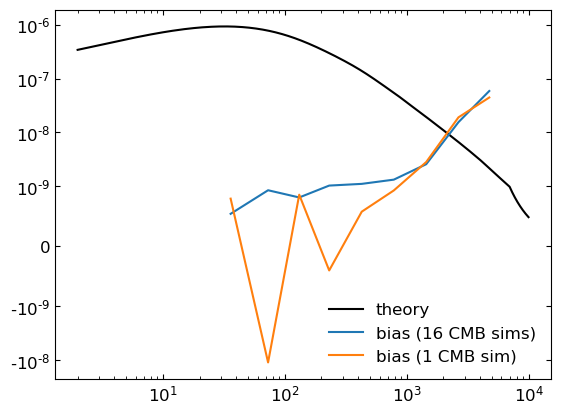

In [71]:
loglog(ℓ⁴*Cℓ.total.ϕϕ,"k")
loglog(ℓ⁴*Cℓ_bias)
loglog(ℓ⁴*Cℓ_bias1)
yscale("symlog",linthreshy=1e-9)
# loglog(ℓ⁴*Cℓ_noise)
legend(["theory", "bias (16 CMB sims)", "bias (1 CMB sim)"]);

# Check periodicity

In [36]:
Cϕbig = Cℓ_to_Cov(Flat(Nside=1200,θpix=2),Float32,S0,Cℓ.total.ϕϕ);

In [ ]:
## let ϕ=ϕ2
plot([ϕ[:Ix][1,:]; ϕ[:Ix][1,:]])
plot([ϕ[:Ix][:,1]; ϕ[:Ix][:,1]])
plot([ϕ[:Ix][end÷2,:]; ϕ[:Ix][end÷2,:]])
plot([ϕ[:Ix][:,end÷2]; ϕ[:Ix][:,end÷2]])
title(L"$\phi$")
end

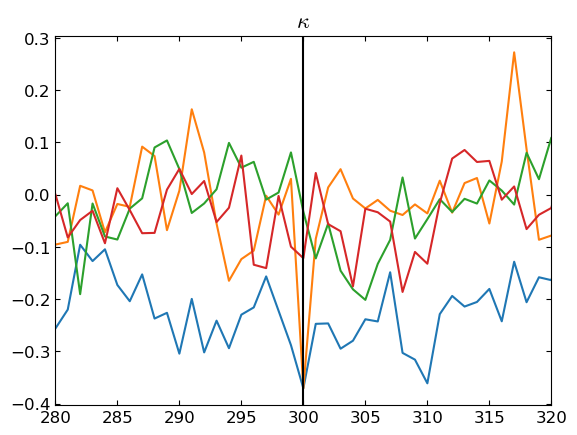

PyObject <matplotlib.lines.Line2D object at 0x2aaad4a5f5d0>

In [50]:
plot([κ[:Ix][1,:]; κ[:Ix][1,:]])
plot([κ[:Ix][:,1]; κ[:Ix][:,1]])
plot([κ[:Ix][end÷2,:]; κ[:Ix][end÷2,:]])
plot([κ[:Ix][:,end÷2]; κ[:Ix][:,end÷2]])
title(L"$\kappa$")
xlim(280,320)
axvline(300,c="k")

# Chains

In [6]:
using FileIO

In [7]:
chains_with    = load("scripts/with_ptsrc_mask.jld2","chains");

In [8]:
chains_without = load("scripts/without_ptsrc_mask.jld2","chains");

In [9]:
using PyCall

In [54]:
py"""
import sys
sys.path.append("/global/homes/m/marius/work/cosmoslik")
"""

In [66]:
using Printf

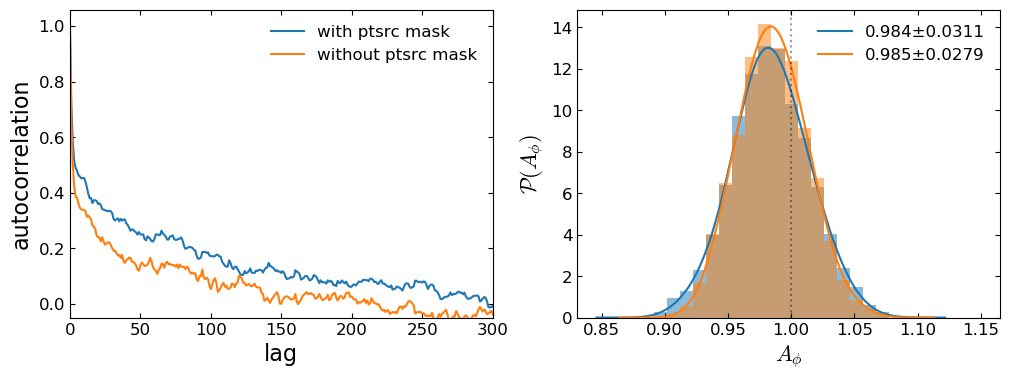

PyObject <matplotlib.legend.Legend object at 0x2aac250b6ed0>

In [83]:
figure(figsize=(12,4))

subplot(121)
for chain in (chain_with, chain_without)
    plot(pyimport("emcee.autocorr").function_1d(map(chain) do samp
        samp[:θ].Aϕ
    end))
end
legend(["with ptsrc mask","without ptsrc mask"])
xlim(0,300)
xlabel("lag")
ylabel("autocorrelation")
ylim(-0.05)

subplot(122)
for (i,chain) in enumerate((chain_with, chain_without))
    samps = map(chain) do samp
        samp[:θ].Aϕ
    end
    hist(samps, normed=true,color="C$(i-1)", alpha=0.5, bins=range(0.85,1.15,length=30))
    pyimport("cosmoslik").like1d(samps,c="C$(i-1)", label=@sprintf("%.3f±%.4f",mean(samps),std(samps)))
end
axvline(1, c="k", ls=":", alpha=0.4)
xlabel(L"A_\phi")
ylabel(L"\mathcal{P}(A_\phi)")
legend()

In [85]:
(311-279)/279

0.11469534050179211

In [10]:
[pyimport("emcee.autocorr").integrated_time([samp[:θ].Aϕ for chain in chains for samp in chain[100:end]], quiet=true) for chains in (chains_with, chains_without)]

N/50 = 69;
tau: [80.88476982]


2-element Array{Array{Float64,1},1}:
 [80.8847698247165] 
 [45.68580369335001]

In [24]:
chain_with, chain_without = ([samp for chain in chains for samp in chain[100:end]] for chains in (chains_with, chains_without));

In [ ]:
hist(chain_wi)

In [37]:
map(chain_without[1:5:end]) do samp
    samp[:θ].Aϕ
#     samp[:ΔH]
end |> std

0.027309931269773897

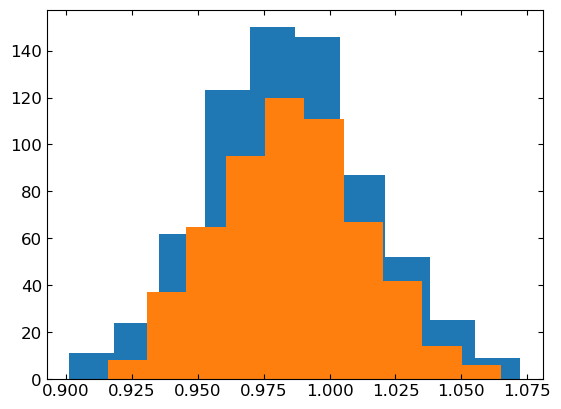

([8.0, 37.0, 65.0, 95.0, 120.0, 111.0, 67.0, 42.0, 14.0, 6.0], [0.9158418732933906, 0.9307551843008999, 0.9456684953084091, 0.9605818063159184, 0.9754951173234276, 0.9904084283309369, 1.0053217393384462, 1.0202350503459554, 1.0351483613534647, 1.050061672360974, 1.0649749833684832], PyObject[PyObject <matplotlib.patches.Rectangle object at 0x2aabe75613d0>, PyObject <matplotlib.patches.Rectangle object at 0x2aabe554a0d0>, PyObject <matplotlib.patches.Rectangle object at 0x2aabe7561d50>, PyObject <matplotlib.patches.Rectangle object at 0x2aabe7561e90>, PyObject <matplotlib.patches.Rectangle object at 0x2aabe7570490>, PyObject <matplotlib.patches.Rectangle object at 0x2aabe7570290>, PyObject <matplotlib.patches.Rectangle object at 0x2aabe7570c10>, PyObject <matplotlib.patches.Rectangle object at 0x2aabe7570f90>, PyObject <matplotlib.patches.Rectangle object at 0x2aabe7561ed0>, PyObject <matplotlib.patches.Rectangle object at 0x2aabe7570850>])

In [33]:
hist(map(chain_with[1:5:end]) do samp
    samp[:θ].Aϕ
end)

hist(map(chain_without[1:5:end]) do samp
    samp[:θ].Aϕ
end)

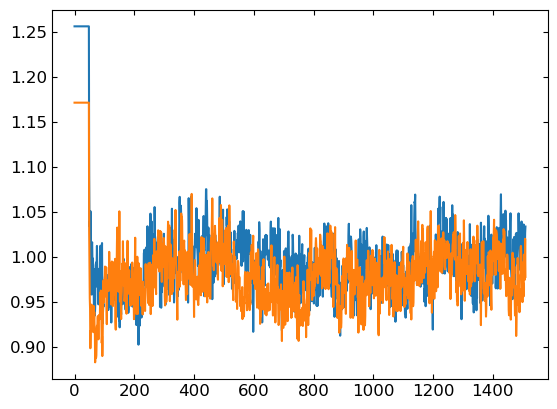

In [15]:
for chain in chains_without
    plot(map(chain[2:end]) do samp
        samp[:θ].Aϕ
#         samp[:ΔH]
    end)
end

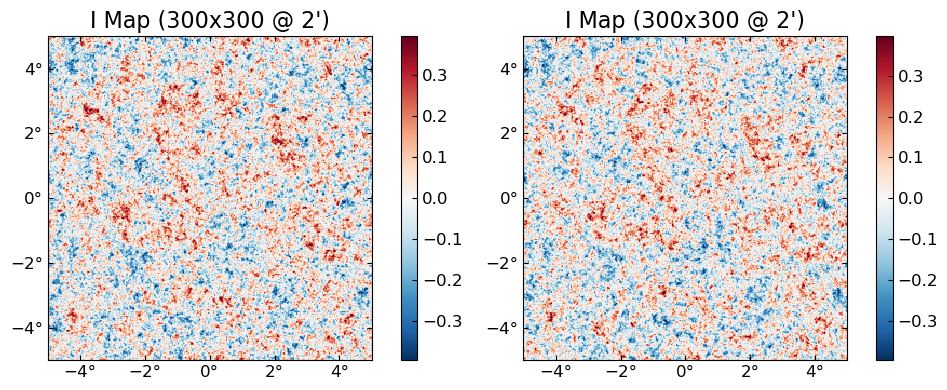

In [98]:
plot([∇²] .* [rundat[:metadata][:ϕ] chains[1][end][:ϕ]])

In [65]:
chains[1][end][:timing]

(f = 0.282783814, θ = 1.766881398, ϕ = 4.056829317)